In [1]:
import tensorflow
print(tensorflow.__version__)

2.19.0


In [2]:
import tensorflow as tf
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 수집

In [4]:
path = "C:/Users/yjneo/AIFFEL_quest_rs/Exploration/Ex07/ChatbotData.csv"
data = pd.read_csv(path)
data.sample(5)

,Q,A,label
5088,향수 뿌려도 될라나,향기 나면 좋아요.,0
4784,클럽가고 싶은데 말하고 갈까,말하고 가거나 같이 가보세요.,0
8790,후련해,후련하다니 다행이에요.,1
3227,연예인 되면 피곤하겠지?,아무래도 사생활이 적으니까요.,0
1584,머리 깎아야겠다.,예쁘게 깎아요!,0


# 2. 데이터 전처리

In [6]:
import re

def preprocess_sentence(sentence):
    # 1. 양쪽 공백 제거
    sentence = sentence.strip()

    # 2. 주요 구두점(?, !, ,)은 띄어쓰기로 분리 (마침표는 제거)
    sentence = re.sub(r"([?!,])", r" \1 ", sentence)

    # 3. 한글, 영문, 숫자, 주요 구두점(?, !, ,)만 남기고 나머지는 제거
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?!,]", " ", sentence)

    # 4. 여러 공백을 하나로 줄이기
    sentence = re.sub(r"\s+", " ", sentence).strip()

    return sentence



In [7]:
# 데이터를 로드하고 질문을 questions, 답변을 answers에 저장합니다.

questions_raw= list(data['Q'])
answers_raw = list(data['A'])
print('전체 샘플 수 :', len(questions_raw))
print('전체 샘플 수 :', len(answers_raw))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


### 결측치 확인

In [ ]:
print(data.isnull().sum())

In [9]:
# 텍스트 전처리
questions = [preprocess_sentence(sentence) for sentence in questions_raw]
answers = [preprocess_sentence(sentence) for sentence in answers_raw]

### 전처리 확인

In [10]:
for i in range(5):
    print(f"Q{i+1}: {questions_raw[i]}  →  {questions[i]}")
    print(f"A{i+1}: {answers_raw[i]}  →  {answers[i]}")
    print()

Q1: 12시 땡!  →  12시 땡 !
A1: 하루가 또 가네요.  →  하루가 또 가네요

Q2: 1지망 학교 떨어졌어  →  1지망 학교 떨어졌어
A2: 위로해 드립니다.  →  위로해 드립니다

Q3: 3박4일 놀러가고 싶다  →  3박4일 놀러가고 싶다
A3: 여행은 언제나 좋죠.  →  여행은 언제나 좋죠

Q4: 3박4일 정도 놀러가고 싶다  →  3박4일 정도 놀러가고 싶다
A4: 여행은 언제나 좋죠.  →  여행은 언제나 좋죠

Q5: PPL 심하네  →  PPL 심하네
A5: 눈살이 찌푸려지죠.  →  눈살이 찌푸려지죠



# 3. SubwordTextEncoder 사용하기
- 내부 단어 토크나이저인 SubwordTextEncoder를 사용
- 단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고, 각 토큰을 고유한 정수로 인코딩
- 각 문장을 토큰화하고 문장의 시작과 끝에 START_TOKEN, END_TOKEN을 추가
- 최대 길이 MAX_LEN 지정, 최대 길이를 넘는 문장 필터링
- 최대 길이보다 짧은 문장은 맞춰서 패딩

## 단어장 만들기

In [13]:
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size =2**13)
#시작토큰과 종료토큰에 고유한 정수 부여
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [14]:
#단어장 크기 +2
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8183]
END_TOKEN의 번호 : [8184]
8185


## 정수 인코딩, 패딩

### 정수 인코딩, 패딩, 샘플 제거 함수

In [16]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
# print(MAX_LENGTH)

# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 21 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 21으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

### 함수 적용, 확인

In [17]:
questions, answers = tokenize_and_filter(questions, answers)
# ✅ numpy 배열로 변환 (모든 샘플이 MAX_LENGTH로 맞춰져야 함)
questions = np.array(questions, dtype=np.int32)
answers = np.array(answers, dtype=np.int32)

print(questions.shape)  # (전체 샘플 수, MAX_LENGTH)
print(answers.shape)    # (전체 샘플 수, MAX_LENGTH)

(11823, 40)
(11823, 40)


In [18]:
# 0번 샘플을 임의로 출력
print(questions[0])
print(answers[0])

[8183 7922 4210 3061   39 8184    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8183 3843   73 7901 8184    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


##  인코더와 디코더의 입력, 레이블 만들기

In [20]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# questions = np.array(questions, dtype=np.int32)
# answers = np.array(answers, dtype=np.int32)
# # 디코더는 이전의 target을 다음의 input으로 사용합니다.
# # 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
# dataset = tf.data.Dataset.from_tensor_slices((
#     {
#         'inputs': questions,
#         'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
#     },
#     {
#         'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
#     },
# ))


# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [21]:
# for x, y in dataset.take(1):
#     print(x['inputs'].dtype)      # tf.int32
#     print(x['dec_inputs'].dtype)  # tf.int32
#     print(y['outputs'].dtype)     # tf.int32


<dtype: 'int32'>
<dtype: 'int32'>
<dtype: 'int32'>


In [22]:
# # 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
# print(answers[0]) # 기존 샘플
# print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
# print(answers[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8183 3843   73 7901 8184    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8183 3843   73 7901 8184    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3843   73 7901 8184    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


# 4. 모델 구성하기
- 인코더 층 함수
- 디코더 층 함수
- 트랜스포머 함수 정의
- 모델 생성
- 손실 함수
- 커스텀된 학습률
- 모델 컴파일
- 모델 훈련

### 트랜스포머 입력 : 포지셔널 인코딩 레이어

In [24]:
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    i = tf.cast(i, tf.float32)  # i도 명확히 float32로 캐스팅
    angle_rates = 1.0 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return tf.cast(position, tf.float32) * angle_rates



  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        tf.range(position)[:, tf.newaxis],
        tf.range(d_model)[tf.newaxis, :],
        d_model
    )

    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # Tensor 기반으로 재결합
    angle_rads = tf.concat([sines, cosines], axis=-1)

    # 순서 정렬 (짝수-홀수-짝수-홀수가 되도록)
    indices = tf.argsort(tf.range(d_model) % 2 * d_model + tf.range(d_model))
    pos_encoding = tf.gather(angle_rads, indices, axis=1)

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    if isinstance(inputs, tf.SparseTensor):
        inputs = tf.sparse.to_dense(inputs)
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


### 스케일드 닷 어텐션, 멀티헤드 어텐션, 마스킹

In [25]:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        # ✅ tf.Tensor 타입인 mask 처리
        scaled_attention_logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, query, key, value, mask):
    batch_size = tf.shape(query)[0]

    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
    outputs = self.dense(concat_attention)

    return outputs



In [27]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]


### 인코더

In [28]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 셀프 어텐션 (Q = K = V = inputs)
  attention = MultiHeadAttention(d_model, num_heads, name="attention")(
      inputs, inputs, inputs, padding_mask
  )

  # 드롭아웃 + 잔차 연결 + 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드포워드
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결 + 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [29]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(1000, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        dff=dff, d_model=d_model, num_heads=num_heads, dropout=dropout, name=f"encoder_layer_{i}"
    )(inputs=[outputs, padding_mask])

  return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)


### 디코더

In [30]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)


In [31]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 1. 첫 번째 멀티-헤드 어텐션 (마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(d_model, num_heads, name="attention_1")(
      inputs, inputs, inputs, look_ahead_mask
  )
  attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs)

  # 2. 두 번째 멀티-헤드 어텐션 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(
      attention1, enc_outputs, enc_outputs, padding_mask
  )
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1)

  # 3. 포지션 와이즈 피드 포워드
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name
  )


In [32]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):

  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(1000, d_model)(embeddings)  # max_position으로 수정 권장
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
      outputs = decoder_layer(
          dff=dff, d_model=d_model, num_heads=num_heads,
          dropout=dropout, name=f'decoder_layer_{i}'
      )([
          outputs,           # 디코더 현재 입력
          enc_outputs,       # 인코더 출력
          look_ahead_mask,   # 첫 번째 마스크
          padding_mask       # 두 번째 마스크
  ])


  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name
  )


### 트랜스포머

In [33]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더 출력
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      dff=dff,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )([inputs, enc_padding_mask])

  # 디코더 출력
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      dff=dff,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(
      [dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask]
  )

  # 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)


### 손실함수

In [34]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)


### 커스텀된 확습률
- 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

In [35]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

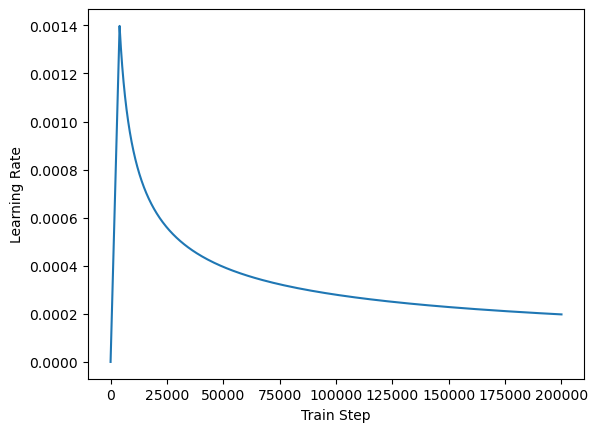

In [36]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


### 모델 생성

In [37]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
D_MODEL = 256
NUM_LAYERS = 2
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)
model.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer)           │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dec_inputs (InputLayer)       │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ enc_padding_mask (Lambda)     │ (None, 1, 1, None)        │               0 │ inputs[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder (Functional)          │ (None, None, 256)         │       3,149,568 │ inputs[0][0],              │
│                               │                           │                 │ enc_padding_mask[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ look_ahead_mask (Lambda)      │ (None, 1, None, None)     │               0 │ dec_inputs[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dec_padding_mask (Lambda)     │ (None, 1, 1, None)        │               0 │ inputs[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder (Functional)          │ (None, None, 256)         │       3,676,928 │ dec_inputs[0][0],          │
│                               │                           │                 │ encoder[0][0],             │
│                               │                           │                 │ look_ahead_mask[0][0],     │
│                               │                           │                 │ dec_padding_mask[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ outputs (Dense)               │ (None, None, 8185)        │       2,103,545 │ decoder[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 8,930,041 (34.07 MB)

 Trainable params: 8,930,041 (34.07 MB)

 Non-trainable params: 0 (0.00 B)

###  모델 컴파일

In [38]:
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # 레이블의 크기는 (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])


In [41]:
# # 1. 반드시 정수형 배열인지 확인
# # questions = np.array(questions, dtype=np.int32)
# # answers = np.array(answers, dtype=np.int32)
# tf.keras.backend.clear_session()  # 모델 세션 초기화 
# # 2. Dataset 생성 시, slicing 정확히!
# new_dataset = tf.data.Dataset.from_tensor_slices((
#     {
#         'inputs': questions,
#         'dec_inputs': answers[:, :-1]
#     },
#     {
#         'outputs': answers[:, 1:]
#     },
# ))

# # 3. batch, shuffle, prefetch
# new_dataset = new_dataset.shuffle(BUFFER_SIZE)
# new_dataset = new_dataset.batch(BATCH_SIZE)
# new_dataset = new_dataset.prefetch(tf.data.AUTOTUNE)


In [42]:
# for x, y in new_dataset.take(1):
#     print("inputs:", x['inputs'].shape)      # ✅ (batch_size, seq_len)
#     print("dec_inputs:", x['dec_inputs'].shape)
#     print("outputs:", y['outputs'].shape)


inputs: (64, 40)
dec_inputs: (64, 39)
outputs: (64, 39)


##  모델 학습

In [80]:
from tensorflow.keras.callbacks import EarlyStopping
# #콜백정의
# early_stopping = EarlyStopping(
#     monitor='val_loss',     # 감시할 값
#     patience=3,             # 3 epoch 동안 개선 없으면 멈춤
#     restore_best_weights=True,  # 성능 가장 좋았을 때의 가중치 복원
#     verbose=1
# )

# from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint = ModelCheckpoint(
#     filepath='best_model.h5',  # 저장 파일 경로
#     monitor='val_loss',
#     save_best_only=True,       # 가장 좋은 성능일 때만 저장
#     save_weights_only=True,    # 가중치만 저장
#     verbose=1
# )
# callbacks = [early_stopping, lr_scheduler, checkpoint]


EPOCHS = 50
x = {
    'inputs': questions,
    'dec_inputs': answers[:, :-1]
}
y = answers[:, 1:]

model.fit(x, y, batch_size=BATCH_SIZE, epochs=EPOCHS)


Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 110s 591ms/step - accuracy: 0.0317 - loss: 0.8910
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 105s 568ms/step - accuracy: 0.0356 - loss: 0.8332
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 104s 564ms/step - accuracy: 0.0414 - loss: 0.7645
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 109s 590ms/step - accuracy: 0.0486 - loss: 0.6880
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 101s 544ms/step - accuracy: 0.0574 - loss: 0.6077
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 114s 614ms/step - accuracy: 0.0668 - loss: 0.5269
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 104s 559ms/step - accuracy: 0.0772 - loss: 0.4421
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 105s 566ms/step - accuracy: 0.0889 - loss: 0.3593
Epoch 9/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 110s 595ms/step - accuracy: 0.1010 - loss: 0.2796
Epoch 10/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 113s 613ms/step - accuracy: 0.1112 - loss: 0.2098
Epoch 11/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 106s 571ms/step - accuracy: 0.1212 - loss: 0.1533
Epoch 12

# 5. 모델 평가
- 데이터 전처리 방법과 inference 단계를 고려하여 decoder_inference() 만들기
- decoder_inference() 를 호출하여 대답을 얻는 sentence_generation()함수 만들기
- 임의의 문장으로부터 챗봇의 대답을 얻기
- 정량적 평가지표 사용

In [83]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [85]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [89]:
#임의의 문장으로부터 챗봇의 대답을 얻어보자
sentence_generation("오늘 너무 우울해")
print('='*30)
sentence_generation("시험 망쳤어")
print('='*30)
sentence_generation("나 오늘 생일이야")
print('='*30)
sentence_generation("친구랑 싸웠어")
print('='*30)
sentence_generation("날씨가 너무 좋다")

입력 : 오늘 너무 우울해
출력 : 제 앞에서 울어도 돼요
입력 : 시험 망쳤어
출력 : 그게 고 싶나봐요
입력 : 나 오늘 생일이야
출력 : 저도 커피 좋아해요
입력 : 친구랑 싸웠어
출력 : 싸우면서 정 들 거예요
입력 : 날씨가 너무 좋다
출력 : 좋은 사람이 찾아오려나봐요


'좋은 사람이 찾아오려나봐요'

- 문법적으로 자연스럽고 사람처럼 표현하지만 가끔 맥락 이해의 한계가 보임
- 일부 입력에 대해서는 적절한 공감형 응답 생성, 몇몇 응답은 입력과 무관

### 이상적인 답변과 비교해보기

In [106]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  # print('입력 : {}'.format(sentence))
  # print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

smoothie = SmoothingFunction().method4

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
smoothie = SmoothingFunction().method4

# 입력 문장, 이상적 참조 문장 직접 지정 : 공감, 제안, 위로 등의 일상 대화 스타일
custom_data = [
    ("혼자 있고 싶어", "그럴 땐 혼자만의 시간도 소중하죠."),
    ("요즘 너무 바빠", "무리하지 말고 잠깐 쉬어가는 것도 좋아요."),
    ("졸려 죽겠어", "조금 눈 붙이는 건 어때요?"),
    ("누가 나한테 짜증냈어", "기분 상했겠어요."),
    ("이번 주말에 뭐하지?", "산책이나 영화 보러 가는 건 어때요?")
]

bleu_scores = []

for input_text, target_text in custom_data:
    predicted_text = sentence_generation(input_text)  # 챗봇 예측값

    reference = [target_text.split()]
    candidate = predicted_text.split()

    bleu = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    bleu_scores.append(bleu)

    print(f"입력 문장 : {input_text}")
    print(f"이상적인 응답 : {target_text}")
    print(f"챗봇의 응답 : {predicted_text}")
    print("="*40)



입력 문장 : 혼자 있고 싶어
이상적인 응답 : 그럴 땐 혼자만의 시간도 소중하죠.
챗봇의 응답 : 혼자만 있지 마세요
입력 문장 : 요즘 너무 바빠
이상적인 응답 : 무리하지 말고 잠깐 쉬어가는 것도 좋아요.
챗봇의 응답 : 하나씩 하세요
입력 문장 : 졸려 죽겠어
이상적인 응답 : 조금 눈 붙이는 건 어때요?
챗봇의 응답 : 사랑에 빠졌나봐요
입력 문장 : 누가 나한테 짜증냈어
이상적인 응답 : 기분 상했겠어요.
챗봇의 응답 : 좋아하는 것을 해보세요
입력 문장 : 이번 주말에 뭐하지?
이상적인 응답 : 산책이나 영화 보러 가는 건 어때요?
챗봇의 응답 : 저랑 이야기해요


# 회고
- 챗봇 응답의 말투, 스타일, 감정의 결이 조언적이고, 이상적인 답변을 감정적 공감이라고 했을 때 둘의 차이가 확연하게 보였다.
- 응답 스타일을 다양하게 시도해보면 좋을 거 같다.
- 감정 태깅을 통한 맞춤형 응답 생성
  입력 문장에 담긴 감정을 정확히 파악하고 태깅함으로써, 더 적절하고 감정에 공감하는 응답을 생성할 수 있을 것으로 기대된다.